In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from param_inference import MyStochasticProcess, distance, newcases_seir
from pyabc import ABCSMC, RV, Distribution, AggregatedTransition, DiscreteJumpTransition, MultivariateNormalTransition, GridSearchCV
from pyabc.visualization import *
from pyabc.weighted_statistics import *
from calc_observables import *
from seir_model import SEIR_Simulator
from datetime import date, datetime, timedelta
from networkx import watts_strogatz_graph
import matplotlib.dates as mdates


In [2]:
figwidth = 6.224
golden_ratio = 1.61803
figsize = (figwidth, figwidth / golden_ratio)
import matplotlib as mpl
# plt.style.use('seaborn-white')
sns.set_style("ticks")
sns.set_palette('colorblind')
mpl.rcParams['figure.figsize'] = figsize
mpl.rcParams['font.sans-serif'] = ['Open Sans']

In [3]:
n = int(3e5)
k_domain = np.arange(1, 11)
data2 = np.load('casespm_de_mar16_jun6.npy') * n / 1e6
data3 = np.load('casespm_de_jun7_sep15.npy') * n / 1e6
data1 = np.load('cases_de_feb26_mar16.npy')
t1 = len(data1)
t2 = len(data2)
t3 = len(data3)

In [4]:
def run1(pars, n, tmax):
    graphparams = {'n': n, 'k': 2*round(pars['k']), 'p': 10 ** (-pars['log_p'])}
    nw = SEIR_Simulator(graphtype='watts strogatz', graphparams=graphparams, p_inf=pars['p_inf'], printing=False)
    nw.set_states_random(round(pars['n02']), 'infected', randomize_waitingtime=False)
    nw.set_states_random(round(pars['n01']), 'exposed', randomize_waitingtime=False)
    nw.timeevo(tmax=tmax, recordfull=False, printprogress=False)
    cases = newcases_seir(nw.n_t)
    return cases, nw.n_t
        
def run2(pars1, pars2, n, t1, t2):
    graphparams = {'n': n, 'k': 2*round(pars1['k']), 'p': 10 ** (-pars1['log_p'])}
    nw = SEIR_Simulator(graphtype='watts strogatz', graphparams=graphparams, p_inf=pars1['p_inf'], printing=False)
    nw.set_states_random(round(pars1['n02']), 'infected', randomize_waitingtime=False)
    nw.set_states_random(round(pars1['n01']), 'exposed', randomize_waitingtime=False)
    nw.timeevo(tmax=t1, recordfull=False, printprogress=False)
    cases1 = newcases_seir(nw.n_t)
    n_t1 = nw.n_t.copy()
    nw.G = watts_strogatz_graph(n, 2*round(pars2['k']), 10 ** (-pars2['log_p']))
    nw.set_parameter('p_inf', pars2['p_inf'])
    nw.timeevo(tmax=t2, recordfull=False, printprogress=False)
    cases2 = newcases_seir(nw.n_t)
    n_t2 = nw.n_t.copy()
    return cases1, n_t1, cases2, n_t2


In [5]:
prior = Distribution(n01=RV('uniform', 0, int(data1.max())),
                     n02=RV('uniform', 0, 10 * int(data1.max())),
                     k=RV('randint', 1, 11),
                     log_p=RV('uniform', 0, 6),
                     p_inf=RV('uniform', 0.01, 0.03))
model = MyStochasticProcess(n, t1, data1)
# transition = AggregatedTransition(mapping={
#     # 'n01': DiscreteJumpTransition(domain=np.arange(int(data.max()))),
#     # 'n02': DiscreteJumpTransition(domain=np.arange(10 * int(data.max()))),
#     'k': DiscreteJumpTransition(domain=k_domain, p_stay=0.7),
#     ('n01', 'n02', 'log_p', 'p_inf'): MultivariateNormalTransition(scaling=0.7)})

ids = ['early_growth', 'n=3e5_2', 'n=3e5_late']

In [ ]:
# runs with random sampling from posterior distribution
params = []
for id in ids:
    db = "sqlite:///" + os.path.join(os.getcwd(), id+".db")
    hid = int(np.load('run_id_'+id+'.npy'))
    abc = ABCSMC(model, prior, distance)
    abc.load(db, hid)
    history = abc.history
    df, w = history.get_distribution()
    kde = GridSearchCV().fit(df, w)
    params.append(kde.rvs(size=reps))
    
    
for i in range(2):
    params[i].loc[params[i].n01 < 0, 'n01'] = 0
    params[i].loc[params[i].n02 < 0, 'n02'] = 0

In [ ]:
# runs with random sampling from posterior distribution
cases = [np.empty((reps, t1), dtype=np.uint), np.empty((reps, t2), dtype=np.uint), np.empty((reps, t3), dtype=np.uint)]
for i in range(reps):
    cases[0][i], _ = run1(params[0].iloc[i], n, t1)
#     cases[1][i], _ = run1(params[1].iloc[i], n, t2)
    cases[1][i], _, cases[2][i], _ = run2(params[1].iloc[i], params[2].iloc[i], n, t2, t3)

In [8]:
def get_means(df, w):
    means = [weighted_mean(df[param].to_numpy(), w) for param in df]
    return means

def get_medians(df, w):
    medians = [weighted_median(df[param].to_numpy(), w) for param in df]
    return medians

In [27]:
# runs with weighted medians as parameters
params = []
for id in ids:
    db = "sqlite:///" + os.path.join(os.getcwd(), id+".db")
    hid = int(np.load('run_id_'+id+'.npy'))
    abc = ABCSMC(model, prior, distance)
    abc.load(db, hid)
    history = abc.history
    df, w = history.get_distribution()
    params.append(dict(zip(df, get_medians(df,w))))

In [28]:
cases = [np.empty((reps, t1), dtype=np.uint), np.empty((reps, t2), dtype=np.uint), np.empty((reps, t3), dtype=np.uint)]
for i in range(reps):
    cases[0][i], _ = run1(params[0], n, t1)
#     cases[1][i], _ = run1(params[1].iloc[i], n, t2)
    cases[1][i], _, cases[2][i], _ = run2(params[1], params[2], n, t2, t3)

In [6]:
PATH = '.\\data\\'
df = pd.read_csv(PATH+'covid_19_data.csv', parse_dates =["ObservationDate", 'Last Update'])  # more up-to-date dataset from kaggle: https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset
interesting_countries = ['Germany']
populations = pd.read_csv(PATH+'worldometer_data.csv', index_col='Country/Region', delimiter=';')['Population'] # get info on population from worldometer
df.rename(columns={'Country/Region': 'Country', 'ObservationDate': 'Date'}, inplace=True)
df = df.loc[df['Country'].isin(interesting_countries)].reset_index()
df.drop(['Last Update', 'Province/State', 'SNo'], axis=1, inplace=True)
df = df.groupby(['Country', 'Date']).agg(sum).reset_index().drop(['index'], axis=1)
df['New cases'] = df.groupby('Country')['Confirmed'].diff()
calc_observables(df, populations)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
C:\Users\simon\PycharmProjects\covidnetwork\calc_observables.py:34: RuntimeWarning: divide by zero encountered in true_divide
  R[tlag:] = active[tlag:] / active[:-tlag]


In [7]:
dates1 = pd.date_range(start='27/2/2020', periods=len(data1))
dates2 = pd.date_range(start='17/3/2020', periods=len(data2))
dates3 = pd.date_range(start='06/08/2020', periods=len(data3))
data = np.concatenate([data1, data2 / n * populations['Germany'], data3 / n * populations['Germany']])
alldates = np.concatenate([dates1, dates2, dates3])

In [8]:
allcases = np.load('casesalltimes100reps_realmedian.npy')
reps = 100

In [32]:
cases[1] = cases[1].astype('float')
cases[2] = cases[2].astype('float')
cases[1] *= populations['Germany'] / n
cases[2] *= populations['Germany'] / n
allcases = np.hstack(cases)

In [8]:
allcases.shape

(100, 198)

In [46]:
# np.save('casesalltimes100reps_realmedian.npy', allcases)

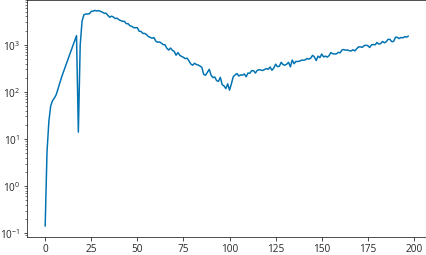

In [9]:
plt.plot(allcases.mean(0))
plt.yscale('log')

(10, 10000)

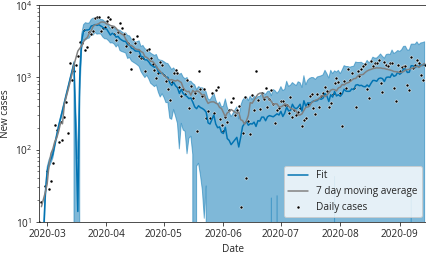

In [8]:
plot_errorshade(alldates, allcases.mean(0) , allcases.std(0, ddof=1), label='Fit')
# plt.plot(dates1, cases[0].mean(0))
# plt.plot(dates2[1:], cases[1][:, 1:].mean(0))
# plt.plot(dates3, cases[2].mean(0))
plt.plot(alldates, data, label='7 day moving average', color='Gray')
sns.scatterplot(data=df, x='Date', y='New cases', label='Daily cases', color='black', marker='.', )
plt.xlim([date(2020, 2, 26), date(2020, 9, 15)])
plt.legend()
plt.yscale('log')
plt.ylim(10, 10000)
# plt.savefig('whatswrongwiththelastperiod.png')

In [8]:
dfn = pd.DataFrame(allcases.flatten(), columns=['cases'])

In [9]:
dfn['Date'] = np.tile(alldates, reps)

In [10]:
dfn['instance'] = np.repeat(np.arange(reps), len(alldates))

In [11]:
dfn['rolling'] = dfn.groupby(['instance'], as_index=False).rolling(7, on='Date', center=True, freq='D', min_periods=4)['cases'].mean().reset_index()['cases']

In [12]:
dfn.loc[dfn.Date < datetime(2020, 3, 16), 'Phase'] = 'pre-LD'
dfn.loc[dfn.Date >= datetime(2020, 3, 16), 'Phase'] = 'LD'
dfn.loc[dfn.Date > datetime(2020, 6, 5), 'Phase'] = 'post-LD'

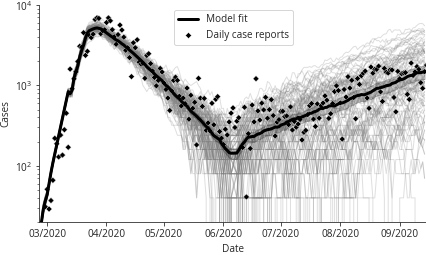

In [32]:
w = figwidth
lw = 3
# sns.lineplot(data=dfn, x='Date', y='rolling', estimator=np.mean, ci=95, hue='Phase', palette=('C0', 'C2', 'C1'), linewidth=lw, legend=None)
sns.lineplot(data=dfn, x='Date', y='rolling', estimator=np.mean, ci=95, linewidth=lw, legend=None, color='k', label='Model fit')

sns.scatterplot(data=df, x='Date', y='New cases', label='Daily case reports', color='black', marker='D', size=10, legend=None)
# plt.plot(alldates, data, label='7 day average', color='Black')
sns.lineplot(data=dfn, x='Date', y='rolling', palette=['Gray']*reps, alpha=0.25, hue='instance', 
             estimator=sum, ci=None, zorder=-1, legend=None, linewidth=1)
# sns.lineplot(data=ncdf, x='Date', y='Rolling new cases', color='red')
# sns.lineplot(data=ncdf, x='Date', y='New cases', color='blue')
plt.xlim([date(2020, 2, 26), date(2020, 9, 15)])
plt.yscale('log')
plt.ylim(20, 10000)
plt.ylabel('Daily cases')
# plt.axvline(date(2020, 3, 15), lw=3, color='C2', label='Lockdown')
# plt.axvline(date(2020, 6, 5), lw=3, color='C1', label='Removal of NPIs')
dtFmt = mdates.DateFormatter('%m/%Y') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
plt.legend()
plt.ylabel('Cases')
sns.despine()
# plt.savefig('figures\\datacomparison2.svg', bbox_inches='tight', pad_inches=0)